In [1]:
library(gridExtra)
library(igraph)
library(ggplot2)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'ggplot2' was built under R version 3.5.1"

In [2]:
# Reading in the graph, and viewing its brief summary

pl_graph <- read.graph(file = "pl.gml.txt", format = "gml")

summary(pl_graph)

IGRAPH 4ba65df D--- 582 2810 -- 
+ attr: id (v/n), label (v/c), graphics (v/c), fan_count (v/c),
| category (v/c), username (v/c), users_can_post (v/c), link (v/c),
| post_activity (v/c), talking_about_count (v/c), Yala (v/c), id (e/n),
| value (e/n)


In [18]:
# Inspecting the page graph object

pl_df <- data.frame(id = V(pl_graph)$id,
                    name = V(pl_graph)$label,
                    category = V(pl_graph)$category,
                    fans = as.numeric(V(pl_graph)$fan_count),
                    talking_about = as.numeric(V(pl_graph)$talking_about_count),
                    post_activity = as.numeric(V(pl_graph)$post_activity),
                    stringsAsFactors = FALSE
                   )

# View(pl_df) won't work in Jupyter notebook

head(pl_df)

id,name,category,fans,talking_about,post_activity
10,Premier League,Sports League,39301910,634081,0.31
20,TAG Heuer,Jewelry/Watches,2823063,30796,0.14
30,Carling,Food & Beverage Company,200508,12078,0.03
40,Hull Tigers,Sports Team,1000560,40500,0.23
50,Middlesbrough FC,Sports Team,431967,25042,0.29
60,Burnley Football Club,Sports Team,352042,3279,0.19


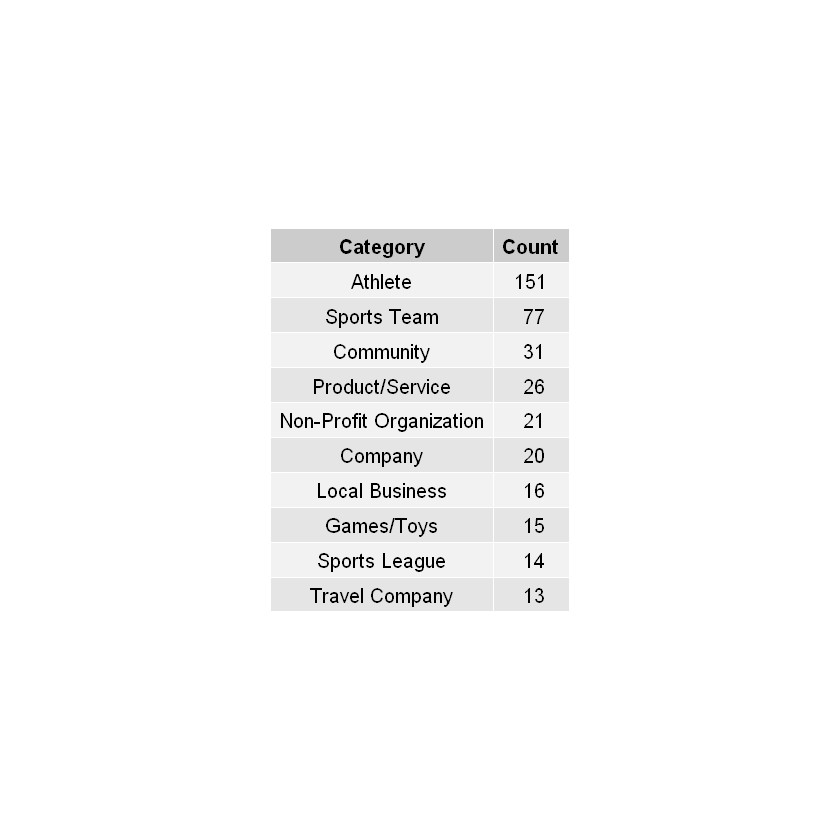

In [4]:
# Aggregating pages based on their category

grid.table(as.data.frame(sort(table(pl_df$category),
                              decreasing = TRUE)[1:10]),
           rows = NULL,
           cols = c('Category', 'Count'))

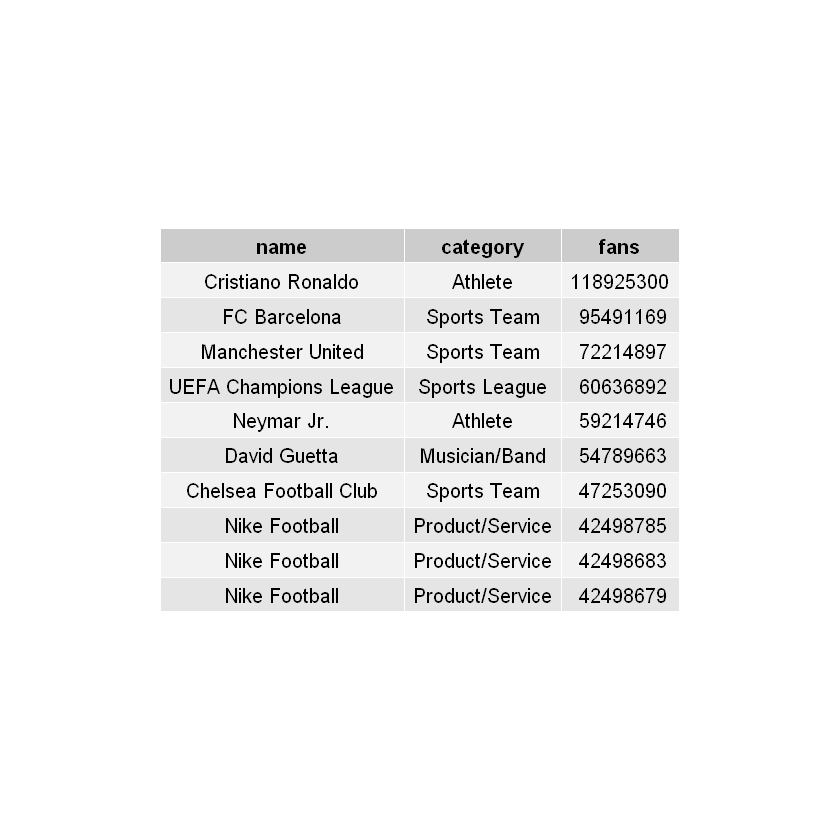

In [5]:
# Top pages based on their fan count (likes)

grid.table(pl_df[order(pl_df$fans, decreasing = TRUE),
                 c('name', 'category', 'fans')][1:10, ],
           rows = NULL)

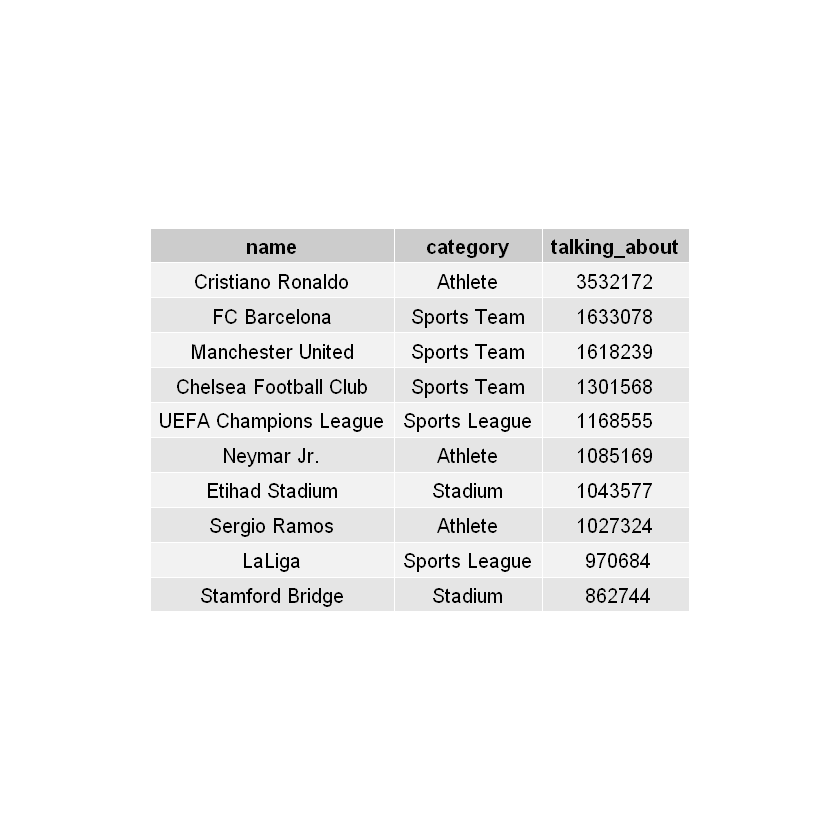

In [6]:
# Top pages based on total people talking about them

grid.table(pl_df[order(pl_df$talking_about, 
                       decreasing = TRUE), 
                 c('name', 'category', 'talking_about')][1:10, ],
           rows = NULL)

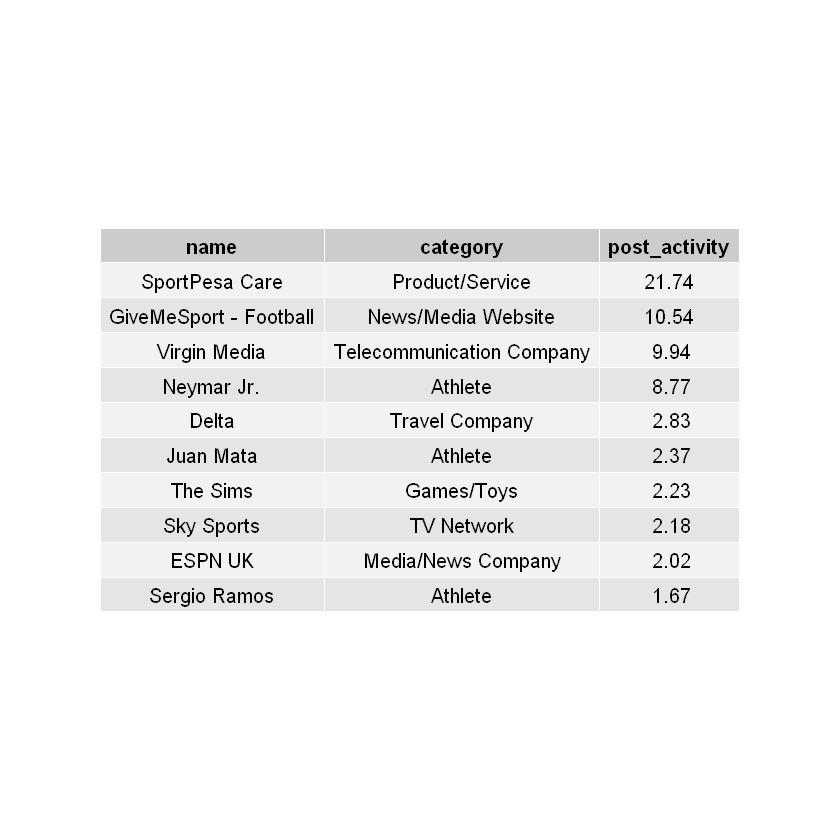

In [7]:
# Top pages based on page posting activity

grid.table(pl_df[order(pl_df$post_activity,
                       decreasing = TRUE),
                 c('name', 'category', 'post_activity')][1:10, ],
           rows = NULL)

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous y-axis"Warning message:
"Removed 6 rows containing missing values (geom_point)."

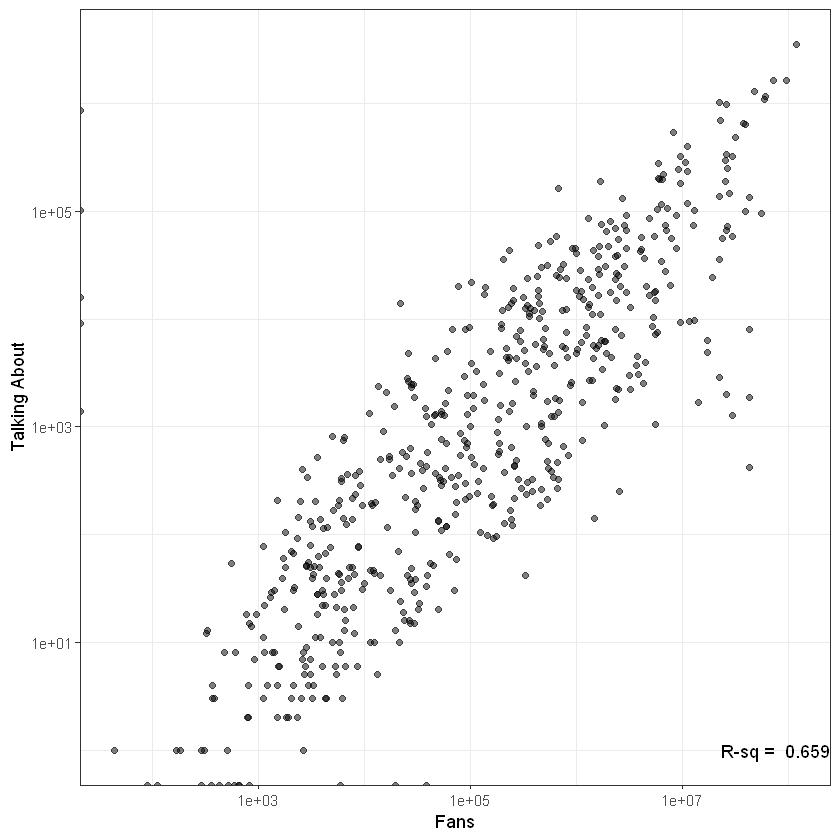

In [8]:
# Checking correlation between fans and talking_about 
# for pages

clean_pl_df <- pl_df[complete.cases(pl_df), ]
rsq <- format(cor(clean_pl_df$fans, 
                  clean_pl_df$talking_about) ^ 2, digits = 3)
corr_plot <- ggplot(pl_df, aes(x = fans, y = talking_about)) +
               theme_bw() +
               geom_jitter(alpha = 1/2) +
               scale_x_log10() +
               scale_y_log10() +
               labs(x = "Fans", y = "Talking About") +
               annotate("text", label = paste("R-sq = ", rsq),
                         x = +Inf, y = 1, hjust = 1)

corr_plot

In [9]:
# For plotting page network using degree filter

degrees <- degree(pl_graph, mode = "total")
degrees_df <- data.frame(ID = V(pl_graph)$id,
                         Name = V(pl_graph)$label,
                         Degree = as.vector(degrees))

ids_to_remove <- degrees_df[degrees_df$Degree < 30, c('ID')]
ids_to_remove <- ids_to_remove / 10

# Getting filtered graph

filtered_pl_graph <- delete.vertices(pl_graph, ids_to_remove)

# Plotting the graph

tkplot(filtered_pl_graph,
       vertex.size = 10,
       vertex.color = "orange",
       vertex.frame.color = "white",
       vertex.label.color = "black",
       vertex.label.family = "sans",
       edge.width = 0.2,
       edge.arrow.size = 0,
       edge.color = "grey",
       edge.curved = TRUE,
       layout = layout.fruchterman.reingold)

[1] 1

In [10]:
# Diameter (length of longest path) of the network

diameter(pl_graph, directed = TRUE)

[1] 7

In [11]:
# Getting the longest path of the network

get_diameter(pl_graph, directed = TRUE)$label

[1] "Sports Arena Hull"    "Hull Tigers"          "Teenage Cancer Trust"
[4] "Celtic FC"            "Dafabet UK"           "Premier League"      
[7] "Carling"              "Alice Gold"

In [12]:
# Mean distance between 2 nodes in the network

mean_distance(pl_graph, directed = TRUE)

[1] 3.696029

,Premier League,Manchester United,Manchester City,Liverpool FC,Arsenal,Chelsea Football Club
Premier League,0,1,1,1,1,1
Manchester United,1,0,2,2,2,2
Manchester City,1,2,0,2,2,2
Liverpool FC,1,2,2,0,2,2
Arsenal,1,2,2,2,0,2
Chelsea Football Club,1,2,2,2,2,0


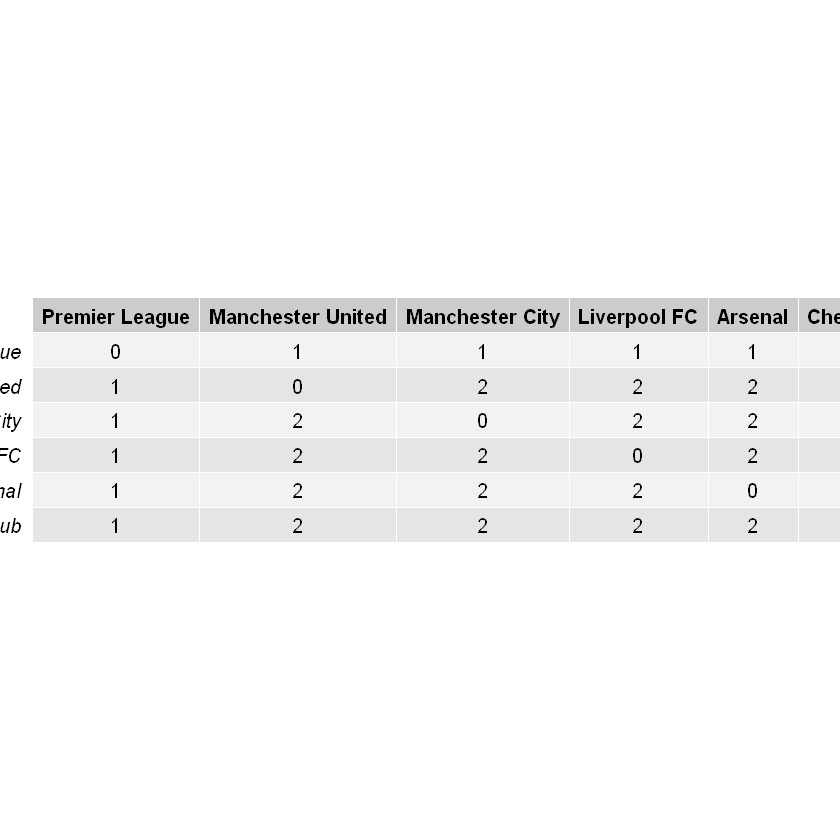

In [13]:
# Distance between various important pages (nodes)

node_dists <- distances(pl_graph, weights = NA)
labels <- c("Premier League", pl_df[c(21, 22, 23,24, 25),
                                    'name'])
filtered_dists <- node_dists[c(1, 21, 22, 23, 24, 25),
                             c(1, 21, 22, 23, 24, 25)]

colnames(filtered_dists) <- labels
rownames(filtered_dists) <- labels
grid.table(filtered_dists)

# View(filtered_dists) will show an error in Jupyter notebook

head(filtered_dists)

In [14]:
# Edge density = no. of edges / no. of all possible edges

edge_density(pl_graph)

[1] 0.008310118

In [15]:
2801 / (582 * 581)

[1] 0.008283502

In [16]:
# Transitivity clustering coefficient

transitivity(pl_graph)

[1] 0.163949

In [17]:
# The k-core of a graph is a maximal subgraph in which each
# vertex has at least degree k.
# The coreness of a vertex is k if it belongs to the k-core
# but not to the (k+1)-core

page_names <- V(pl_graph)$label
page_coreness <- coreness(pl_graph)
page_coreness_df = data.frame(Page = page_names,
                              PageCoreness = page_coreness)
page_coreness_df

Page,PageCoreness
Premier League,11
TAG Heuer,6
Carling,5
Hull Tigers,9
Middlesbrough FC,7
Burnley Football Club,11
Watford FC,9
AFC Bournemouth,9
Leicester City Football Club,10
Crystal Palace Football Club,11


In [19]:
# Max coreness

max(page_coreness_df$PageCoreness)

[1] 11

In [20]:
# Viewing the core of the network

head(page_coreness_df[page_coreness_df$PageCoreness ==
                      max(page_coreness_df$PageCoreness), ], 20)

,Page,PageCoreness
1,Premier League,11
6,Burnley Football Club,11
10,Crystal Palace Football Club,11
11,West Ham United,11
12,Southampton FC,11
14,Everton Football Club,11
15,Nike Football,11
16,West Bromwich Albion,11
17,Tottenham Hotspur,11
18,Swansea City Football Club,11


In [21]:
# Viewing the periphery of the network

head(page_coreness_df[page_coreness_df$PageCoreness ==
                      min(page_coreness_df$PageCoreness), ], 20)

,Page,PageCoreness
34,Henrik Lundqvist,1
37,Cara Delevingne,1
38,La Carrera Panamericana,1
39,Patrick Dempsey,1
40,Dempsey Racing,1
52,The Carling Local at V Festival,1
57,Tigers Trust,1
59,Hull Tigers Commercialâ€™,1
60,Hull Tigers Arabic,1
61,Andy Dawson Testimonial,1


In [22]:
# Degree Centrality

degree_plg <- degree(pl_graph, mode = "total")
degree_plg_df <- data.frame(Name = V(pl_graph)$label,
                            Degree = as.vector(degree_plg))
degree_plg_df <- degree_plg_df[order(degree_plg_df$Degree,
                                     decreasing = TRUE), ]

head(degree_plg_df, 20)

,Name,Degree
22,Manchester City,109
24,Arsenal,92
15,Nike Football,91
19,Sunderland AFC,91
25,Chelsea Football Club,90
1,Premier League,85
21,Manchester United,84
6,Burnley Football Club,82
14,Everton Football Club,65
23,Liverpool FC,59


In [23]:
# Closeness Centrality

closeness_plg <- closeness(pl_graph, mode = "all", 
                           normalized = TRUE)
closeness_plg_df <- data.frame(Name = V(pl_graph)$label,
                               Closeness = as.vector(closeness_plg))
closeness_plg_df <- closeness_plg_df[order(
    closeness_plg_df$Closeness, decreasing = TRUE), ]

head(closeness_plg_df, 20)

,Name,Closeness
1,Premier League,0.5340074
19,Sunderland AFC,0.4874161
6,Burnley Football Club,0.4805624
26,Barclays Football,0.4723577
129,EFL Cup,0.4611111
366,606,0.4469231
243,EA SPORTS FIFA,0.4418251
150,The Offside Rule (We Get It!) Podcast,0.4411541
156,The H and C News Football Pie League,0.4365139
22,Manchester City,0.4342302


In [24]:
# Betweenness Centrality

betweenness_plg <- betweenness(pl_graph)
betweenness_plg_df <- data.frame(Name = V(pl_graph)$label,
                                 Betweenness = as.vector(
                                 betweenness_plg))
betweenness_plg_df <- betweenness_plg_df[order(
  betweenness_plg_df$Betweenness, decreasing = TRUE), ]

head(betweenness_plg_df, 20)

,Name,Betweenness
1,Premier League,96082.154
22,Manchester City,32242.448
19,Sunderland AFC,24583.192
24,Arsenal,22258.680
6,Burnley Football Club,21872.563
15,Nike Football,21232.926
21,Manchester United,19781.410
243,EA SPORTS FIFA,19013.004
25,Chelsea Football Club,18181.458
2,TAG Heuer,16698.681


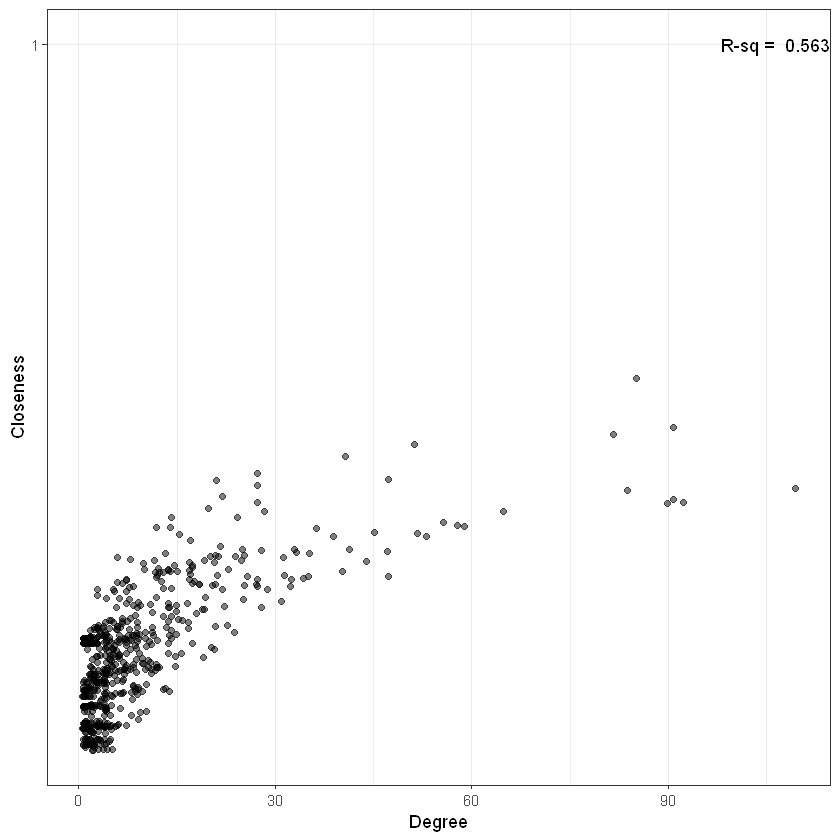

In [25]:
## Correlation Plots

plg_df <- data.frame(degree_plg, closeness_plg, 
                     betweenness_plg)

# Graph 1 - Degree centrality vs. Closeness centrality

rsq <- format(cor(degree_plg, closeness_plg) ^ 2, digits = 3)
corr_plot <- ggplot(plg_df, aes(x = degree_plg,
                                y = closeness_plg)) +
             theme_bw() +
             geom_jitter(alpha = 1/2) +
             scale_y_log10() +
             labs(x = "Degree", y = "Closeness") +
             annotate("text", label = paste("R-sq = ", rsq),
                      x = +Inf, y = 1, hjust = 1)

corr_plot